# Developing MEG Data Preprocessing Pipeline

## Overview
This notebook implements a standardized preprocessing pipeline for OPM-MEG data analysis. 

## Research Context
- **Subject**: variable
- **Data Type**: OPM-MEG recordings (.fif format)

## Preprocessing Steps incuded:
-
-
-


### 0. Importing

In [ ]:
# general packages
import json
import os
import importlib
import sys
import numpy as np
import pandas as pd
from itertools import compress
import matplotlib.pyplot as plt

# ephys packages
import mne
from mne.preprocessing import ICA, compute_proj_hfc
from mne.filter import filter_data, notch_filter

In [ ]:
def add_repo_dir():
    """adds local repo directory to sys to allow importing from repo"""

    wd = os.getcwd()

    COUNTER = 20  #  to prevent eternal while loop

    while not wd.endswith('lid_opm'):
        wd = os.path.dirname(wd)
        COUNTER -= 1

        if COUNTER == 0:
            raise ValueError('repo dir not found!')

    print(f'add repo directory to sys: {wd} ')

    sys.path.append(wd)

    return

In [ ]:
# add custom functions

add_repo_dir()

import utils.load_utils as load_utils
from source_raw_conversion import load_source_opm as source_opm

import source_raw_conversion.load_lsl as loadlsl
import source_raw_conversion.time_syncing as sync
import source_raw_conversion.load_source_opm as sourceopm

import signal_processing.preprocessing as preproc
import signal_processing.preproc_functions as prepr_funcs
import plotting.processing_checks as proc_plotting
import signal_processing.epoching as epoching

## 1. Define settings and load data (incl epoched events)

Define:
- subject
- task
- configuration version
- rename channels to anatomical positions

In [ ]:
CONFIG_VERSION = "v1"

SUB = '03'  # 


# load settings
sub_config = load_utils.load_subject_config(subject_id=SUB,)
preproc_config = load_utils.load_preproc_config(version=CONFIG_VERSION,)
sub_meta_info = load_utils.get_sub_rec_metainfo(config_sub=sub_config)




In [ ]:
importlib.reload(epoching)
importlib.reload(preproc)
importlib.reload(loadlsl)
importlib.reload(sync)
importlib.reload(source_opm)

TASK = 'rest'
ACQ = 'predopa'


recRaw = preproc.rawData_singleRec(
    SUB, TASK, ACQ,
    INCL_OPM=True,
    OPM_PREPROC={
        'resample': True, 'bandpass': True,
        'notch': True, 'hfc': False
    },
    ZSCORE_ACC=True,
    ZSCORE_EMG=True,
)

TMIN, TMAX = -1, 3

opm_epochs, emg_epochs, acc_epochs = epoching.get_epochs(acqClass=recRaw,)

#### explore loaded data objects


In [ ]:
print(recRaw.OPM_Z)
print(recRaw.OPM_Z.info)

#### check sensor layout

In [ ]:
# plot sensor positions
fig = recRaw.OPM_Z.plot_sensors(kind='topomap', show_names=True,to_sphere=True)


Check orientation of first 3 and last 3 orientation normvector rotations

In [ ]:
# run for 3d turning plot

# %matplotlib inline
%matplotlib widget  
# widget requries pip install ipympl

### orientation solving

chnames = recRaw.OPM_Z.ch_names

# chname = '15Z'
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for chname in chnames:
    ch = recRaw.OPM_Z.info['chs'][chnames.index(chname)]
    # print(ch['loc'])
    pos = ch['loc'][:3]            # channel position in meters
    ori_z = ch['loc'][3:6]         # first orientation vector
    ori_y = ch['loc'][6:9]         # second orientation vector (if available)

    # Plot sensor location
    ax.scatter(*pos, c='k', s=20,)

    # Plot orientation vectors (scaled for visibility)
    scale = .005
    ax.quiver(*pos, *ori_z, length=scale, color='r',)
    ax.quiver(*pos, *ori_y, length=scale, color='b',)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.legend()
ax.set_title(f"Orientation vectors ")
plt.close()

In [ ]:
# set back plotting inline

%matplotlib inline

In [ ]:
# TODO: plot the 2n rotation vectors
# TODO: add second orientation axis as [6:9] in load raw opm to mne ~line 550
# coords = source_opm.load_sensor_coords(sub='03',)

#### checking spectral powers (OPM FLUX steps)

In [11]:
n_fft = int(recRaw.OPM_Z.info['sfreq'])
raw_PSD = recRaw.OPM_Z.compute_psd(
    method="welch",
    fmin=0.0, fmax=120,
    picks='mag',
    n_fft=n_fft, n_overlap=int(n_fft/2)
)

Effective window size : 1.000 (s)


Plotting power spectral density (dB=True).


c:\Users\habetsj\Anaconda3\envs\lid_opm\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


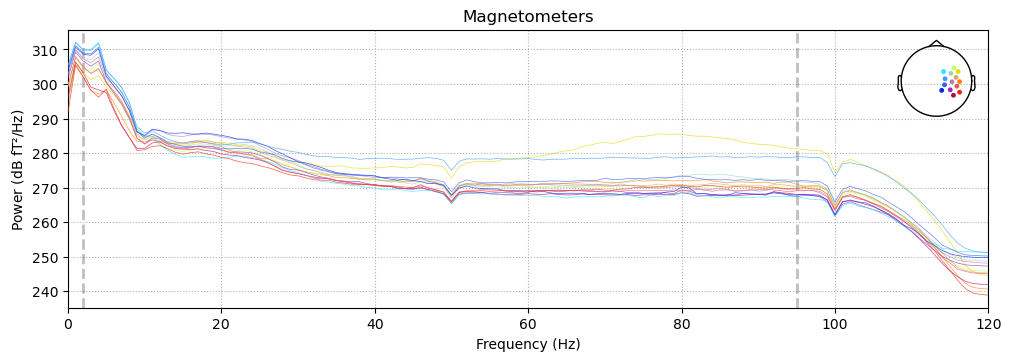

In [12]:
raw_PSD.plot(exclude='bads',picks='mag')

test topogram

visualise to check

In [ ]:
for i, ch in enumerate(sensor_reg[f'{AX_sel}_ch']):

    print(i, ch)
    
    # plt.plot(axdata[:, i])

    # plt.show()

## 2- Resample and Filter  ---> HAPPENS WITHIN LOADING

The following preprocessing steps will be applied to the MEG data to prepare it for analysis:

**Configuration Parameters:**
- Target sampling frequency: 512 Hz
- Bandpass filter: 1-100 Hz  
- Notch filter frequencies: 50, 100, 150 Hz

Resample

In [ ]:
meg_dat = raw.copy()

In [ ]:
# resample
if meg_dat.info['sfreq'] <= preproc_config['TARGET_SFREQ']:
    print(f'original sampling rate {meg_dat.info["sfreq"]} vs defined new rate {preproc_config["TARGET_SFREQ"]}')
else:
    print(f'resample original sampling rate {meg_dat.info["sfreq"]} to {preproc_config["TARGET_SFREQ"]}')
    meg_dat = meg_dat.resample(preproc_config['TARGET_SFREQ'], verbose=False)

# # convert to picoTesla
# meg_dat._data = meg_dat.get_data() * 1e12

Filter

- Bandpass filter
- Notch filter

In [ ]:
temp_dat = meg_dat.copy()

# Bandpass filter (1-100 Hz); use .filter() to remain Raw Mne Object
temp_dat = temp_dat.filter(
    l_freq=preproc_config['BANDPASS_LOW'],
    h_freq=preproc_config['BANDPASS_HIGH'], 
    method='fir', verbose=False,
)  # sfreq=meg_dat.info['sfreq'], is given within Raw Object
meg_dat = temp_dat.copy()

# Apply notch filters (50 Hz and harmonics)
temp_dat = temp_dat.get_data()
for freq in preproc_config['NOTCH_FREQS']:
    temp_dat = notch_filter(
        temp_dat, 
        Fs=meg_dat.info['sfreq'],  
        freqs=freq,
        verbose=False
    )

meg_dat._data = temp_dat

In [ ]:
# fig = meg_dat.plot(start=0, duration=1,)



# fig_dat = meg_dat.get_data()
# N_SEC = 1

# fig, axes = plt.subplots(fig_dat.shape[0])
# for i_ax in np.arange(fig_dat.shape[0]):
    # axes[i_ax].plot(fig_dat[i_ax, :int(N_SEC * meg_dat.info['sfreq'])])

# for ax in axes:
#     ax.

# plt.show()

#### Homogenous Field Correction

Requirements:
- sufficient number of channels
- sufficient head coverage with sensors
- anatomical coordinates of sensors (in FreeSurfer Coordinate Space)

In [ ]:
# Compute HFC projectors
proj_hfc = compute_proj_hfc(meg_dat.info, order=preproc_config['HFC_ORDER'])

# Apply HFC projectors
temp_dat = meg_dat.copy()
meg_dat.add_proj(proj_hfc)
meg_dat.apply_proj()

In [ ]:
fig = meg_dat.plot(start=0, duration=2,)



fig_dat = meg_dat.get_data()
N_SEC = 1

fig, axes = plt.subplots(fig_dat.shape[0])
for i_ax in np.arange(fig_dat.shape[0]):
    axes[i_ax].plot(fig_dat[i_ax, :int(N_SEC * meg_dat.info['sfreq'])])

# for ax in axes:
#     ax.

plt.show()

In [ ]:
events = mne.find_events(trigger_dat, stim_channel='trigger1')
epochs = mne.Epochs(meg_dat, events=events, tmin=-.1, tmax=.3, baseline=None)

In [ ]:
evoked = epochs.average()
plot = evoked.plot()

fig = evoked.plot_joint()


In [ ]:
meg_dat.info['chs']

### 2.2- ICA analysis:

**ICA Configuration:**
- **Method**: FastICA algorithm
- **Components**: 7 (equal to number of MEG channels)
- **Input**: Preprocessed MEG data (512 Hz, filtered)

In [ ]:
from sklearn.decomposition import FastICA

In [ ]:
# ---- ICA ANALYSIS ON MEG CHANNELS ----
print("\n" + "="*60)
print("APPLYING ICA TO MEG CHANNELS")
print("="*60)

# Apply FastICA to the preprocessed MEG data
N_ICA_COMPONENTS = len(meg_dat.ch_names)
ICA_RANDOM_STATE = 0  # For reproducibility
ICA_MAX_ITER = 1000   # Maximum iterations for convergence

# Apply FastICA:
ica = FastICA(
    n_components=N_ICA_COMPONENTS,
    random_state=ICA_RANDOM_STATE,
    # max_iter=ICA_MAX_ITER
)
components = ica.fit_transform(meg_dat.get_data().T).T  # Transpose to (n_times, n_channels), then back

# Create component names for plotting
ICA_COMPONENT_NAMES = [f"ICA-{i+1}" for i in range(N_ICA_COMPONENTS)]
print(f"ICA component names: {ICA_COMPONENT_NAMES}")

In [ ]:
from scipy.signal import welch

In [ ]:
plt.plot(components[0][:10000])

plt.show()

In [ ]:
f, pxx = welch(components[3], fs=meg_dat.info['sfreq'],
                  nperseg=meg_dat.info['sfreq'],)

plt.plot(f, pxx)
plt.show()

### 2.3- Visualise ICA components:

**Objective**: Even in this case the idea is to analyse the ICA components. Here it's possible to decide the time window's lenght in order to have a overall or a more detailed view.

In [ ]:
# ---- VISUALIZE ICA COMPONENTS (60-SECOND WINDOW) ----


# Define ICA visualization window
ICA_WINDOW_DURATION = 60  # sec
ICA_START_TIME = 10       

# Create mask for ICA window
ica_mask = (PREPROCESSED_TIME >= ICA_START_TIME) & (PREPROCESSED_TIME <= ICA_START_TIME + ICA_WINDOW_DURATION)

# Extract windowed data
ica_time_window = PREPROCESSED_TIME[ica_mask]
ica_signals_window = ica_signals[:, ica_mask]

plot_ica_components(
    ica_signals=ica_signals_window,
    time=ica_time_window,
    axis_label="MEG",
    rec_label=f"{SUBJECT_ID} - {CONDITION} ({ICA_WINDOW_DURATION}s: Between {ICA_START_TIME}-{ICA_START_TIME + ICA_WINDOW_DURATION} sec)",
)

print("\n" + "="*60)
print(f"VISUALIZING ICA COMPONENTS - {ICA_WINDOW_DURATION} SECOND WINDOW")
print("="*60)

### 2.4- Select the artifacts:

-**Choose which ICA components you want to remove.**

In [ ]:
# ---- USER CONFIGURATION: ARTIFACT COMPONENTS TO REMOVE ----
print("\n" + "="*60)
print("ICA ARTIFACT REMOVAL CONFIGURATION")
print("="*60)

# USER DEFINES WHICH COMPONENTS ARE ARTIFACTS (1-based: ICA-1, ICA-2, etc.)
ARTIFACT_COMPONENTS = [3, 6]  # Example: Remove ICA-3 and ICA-6

# Remove artifacts from preprocessed data
cleaned_meg_channels = remove_ica_artifacts(
    preprocessed_channels=preprocessed_meg_channels,
    ica_signals=ica_signals,
    ica_model=ica_model,
    artifact_components=ARTIFACT_COMPONENTS,
    verbose=True
)


In [ ]:
# ---- VISUALIZE CLEANED DATA POWER SPECTRA ----
print("\n" + "="*60)
print("POWER SPECTRUM ANALYSIS: CLEANED MEG CHANNELS")
print("="*60)

print(f"Analyzing {len(cleaned_meg_channels)} cleaned MEG channels")
print(f"Sampling frequency: {TARGET_SFREQ} Hz")

plot_all_channel_power_spectra(
    channels=cleaned_meg_channels,
    channel_names=MEG_CHANNEL_NAMES,
    title=f"{SUBJECT_ID} - {CONDITION} (Artifacts Removed: ICA {ARTIFACT_COMPONENTS})",
    sfreq=TARGET_SFREQ,
    window_length=1.0,
    overlap=0.5,
    freq_range=(1, 100)
)

### test topogram


In [ ]:
fname = f'sub{SUB}_{ACQ}_{TASK}_exploring_topogram'
figpath = os.path.join(load_utils.get_onedrive_path('figures'),
                       'explore', fname)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))


for i, (band, fband) in enumerate(
    zip(['low-freq', 'beta', 'gamma'],
        [[4, 12], [15, 30], [65, 85]])
):

    # Band-pass filter raw data
    raw_band = meg_dat.copy().filter(fband[0], fband[1],
                                 fir_design="firwin",)

    # Compute PSD (Power Spectral Density)
    psds, freqs = mne.time_frequency.psd_array_welch(
        raw_band.get_data(),
        sfreq=raw.info['sfreq'],
        fmin=fband[0], 
        fmax=fband[1],
        n_fft=750
    )

    # Average across frequencies in the band
    psd_mean = psds.mean(axis=-1)  # shape (n_channels,)

    # Pick channel info (EEG/MEG sensors only)
    picks = mne.pick_types(raw.info, meg=True, eeg=False)

    # Plot topomap


    topofig, topoax = mne.viz.plot_topomap(
        psd_mean[picks],
        raw.info,
        cmap="viridis",
        show=False,
        axes=axes[i],
    )
    axes[i].set_title(f'{band} activity ({fband[0]}-{fband[1]} Hz)',
                      size=16,)

plt.tight_layout()

plt.savefig(figpath, dpi=300, facecolor='w',)

plt.show()
